# Multi-series multi-step forecaster or Multivariate 

multi-variate: más de una variable respuesta



    We want to monitor weight for a group of patients: This would be multiple time series, i.e. the daily weight values for each patient is a separate time series.

    We want to monitor the health of a single patient, so we keep track of the patient's daily weight, daily body temperature, daily blood pressure, daily cholesterol levels, etc...: This would be a multivariate time series.

     to train a single model to forecast multiple time series at the same time

Single-series forecasters, such as `ForecasterAutoreg`, create models that learn from the lags of a single time series and use this information to make predictions. But, in some cases, there may be 2 or more time series that depend on each other, i.e. past information from one provides information to the other. In these cases, we speak of multivariate time series, and the forecaster is expected not only to learn information from each series separately, but also to relate them.

<p align="center"><img src="../img/diagram-direct-multi-step-forecasting.png" style="width: 700px"></p>

To train a `ForecasterAutoregDirect` a different training matrix is created for each model.

- Introduccion multiseries
- diferencia multivariate y no multivariate con sus diagramas de las matrices
- luego predict
- multiserie lineales (incluyendo la np.random-normal)
- multiserie no lineal (incluyendo la np.random-normal)
- Grid search (seccion grid search)

## Libraries

In [123]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Data

In [86]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})

data.head()

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True
2012-01-04,258955.329422,24.567708,False
2012-01-05,213792.376946,18.191667,False


In [88]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_validation, :].copy()
# data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=1004)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


In [74]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2014-09-30 23:59:00'
end_validation = '2014-10-30 23:59:00'
data_train = data.loc[: end_validation, :].copy()
# data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2014-06-01 00:00:00 --- 2014-10-30 23:00:00  (n=3648)
Validation dates : 2014-10-01 00:00:00 --- 2014-10-30 23:00:00  (n=720)
Test dates       : 2014-10-31 00:00:00 --- 2014-12-30 23:00:00  (n=1464)


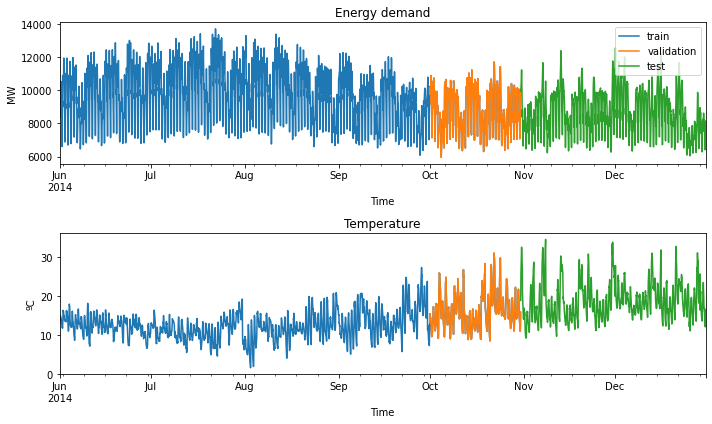

In [75]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_train['Demand'].plot(label='train', ax=axes[0])
data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

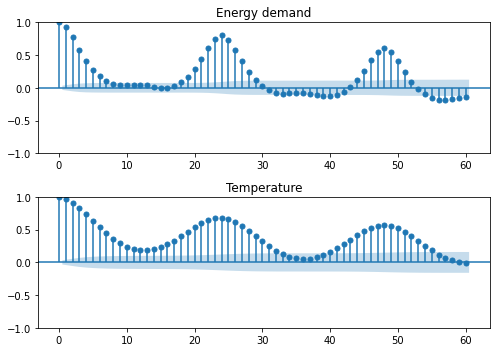

In [76]:
# Autocorrelation plots
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5))

plot_acf(data_train.Demand, ax=axes[0], lags=60)
axes[0].set_title('Energy demand')

plot_acf(data_train.Temperature, ax=axes[1], lags=60)
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

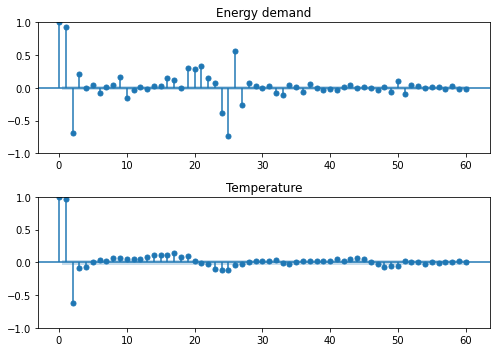

In [77]:
# Autocorrelation plots
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5))

plot_pacf(data_train.Demand, ax=axes[0], lags=60, method='ywm')
axes[0].set_title('Energy demand')

plot_pacf(data_train.Temperature, ax=axes[1], lags=60, method='ywm')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

## Train forecaster

In [89]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 7
             )

forecaster.fit(series=data_train[['Demand', 'Temperature']])
forecaster

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: {'Demand': None, 'Temperature': None} 
Transformer for exog: None 
Window size: 7 
Series levels: ['Demand', 'Temperature'] 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-09-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-16 17:17:36 
Last fit date: 2022-09-16 17:17:37 
Skforecast version: 0.5.0 
Pyt

## Prediction

In [90]:
# Predict
# ==============================================================================
steps = 7

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps, level='Demand')
display(predictions_demand.head(3))

# Predictions for Temperature
predictions_temp = forecaster.predict(steps=steps, level='Temperature')
display(predictions_temp.head(3))

2014-10-01    224415.744224
2014-10-02    235118.376124
2014-10-03    247974.012844
Freq: D, Name: pred, dtype: float64

2014-10-01    17.977240
2014-10-02    18.748729
2014-10-03    17.979719
Freq: D, Name: pred, dtype: float64

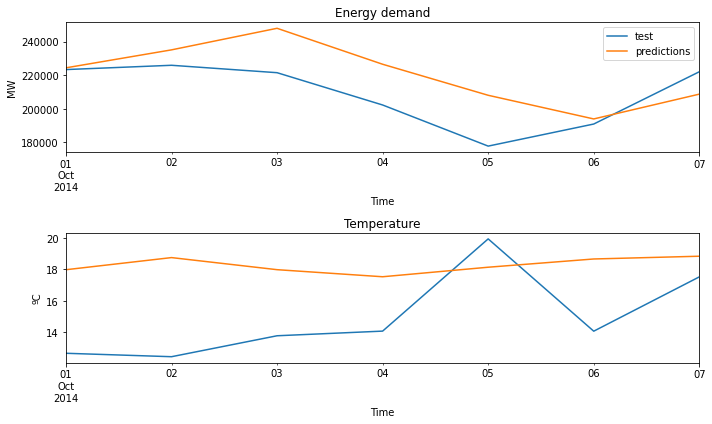

In [91]:
# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# data_train['Demand'].plot(label='train', ax=axes[0])
# data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].iloc[:steps].plot(label='test', ax=axes[0])
predictions_demand.plot(ax=axes[0], label='predictions')
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

# data_train['Temperature'].plot(label='train', ax=axes[1])
# data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].iloc[:steps].plot(label='test', ax=axes[1])
predictions_temp.plot(ax=axes[1], label='predictions')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

In [14]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008419597278831951


### Same with Scaler

Test error (mse): 390884755.04983145


2014-10-01    218195.222553
2014-10-02    225857.935013
2014-10-03    226003.479468
Freq: D, Name: pred, dtype: float64

Test error (mse): 25.80091724480408


2014-10-01    19.718042
2014-10-02    18.686000
2014-10-03    15.077962
Freq: D, Name: pred, dtype: float64

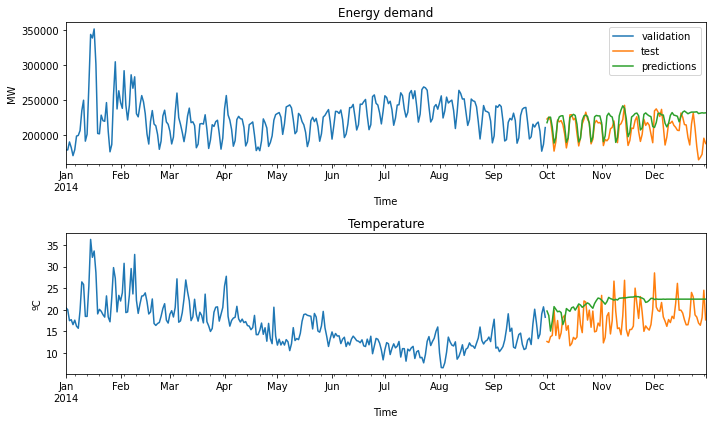

,feature,importance
0,lag_1,0.572190
1,lag_2,0.069218
2,lag_3,0.040535
3,lag_4,0.043591
4,lag_5,0.054780
5,lag_6,0.069362
6,lag_7,0.138796
7,Demand,0.005967
8,Temperature,0.005560


In [98]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 7,
                 transformer_series = StandardScaler()
             )

forecaster.fit(series=data_train[['Demand', 'Temperature']])

# Predict
# ==============================================================================
steps = len(data_test)

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps, level='Demand')
error_mse = mean_squared_error(
                y_true = data_test.Demand,
                y_pred = predictions_demand
            )
print(f"Test error (mse): {error_mse}")
display(predictions_demand.head(3))

# Predictions for Temperature
predictions_temp = forecaster.predict(steps=steps, level='Temperature')
error_mse = mean_squared_error(
                y_true = data_test.Temperature,
                y_pred = predictions_temp
            )
print(f"Test error (mse): {error_mse}")
display(predictions_temp.head(3))

# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# data_train['Demand'].plot(label='train', ax=axes[0])
data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(ax=axes[0], label='predictions')
axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

# data_train['Temperature'].plot(label='train', ax=axes[1])
data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(ax=axes[1], label='predictions')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

forecaster.get_feature_importance()

Test error (mse): 516663255.13775516


2014-10-01    221543.349252
2014-10-02    233125.821312
2014-10-03    234321.028870
Freq: D, Name: pred, dtype: float64

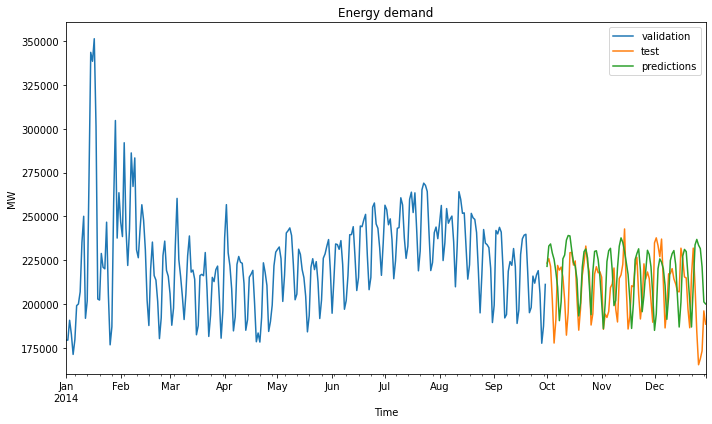

,feature,importance
0,lag_1,0.647103
1,lag_2,0.201283
2,lag_3,0.151613


In [100]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 3,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data_train['Demand'])

# Predict
# ==============================================================================
steps = len(data_test)

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps)
error_mse = mean_squared_error(
                y_true = data_test.Demand,
                y_pred = predictions_demand
            )
print(f"Test error (mse): {error_mse}")
display(predictions_demand.head(3))

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
predictions_demand.plot(ax=ax, label='predictions')
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend()

fig.tight_layout()
plt.show();

forecaster.get_feature_importance()

Test error (mse): 13.804554011785527


2014-10-01    17.945396
2014-10-02    18.757438
2014-10-03    19.020375
Freq: D, Name: pred, dtype: float64

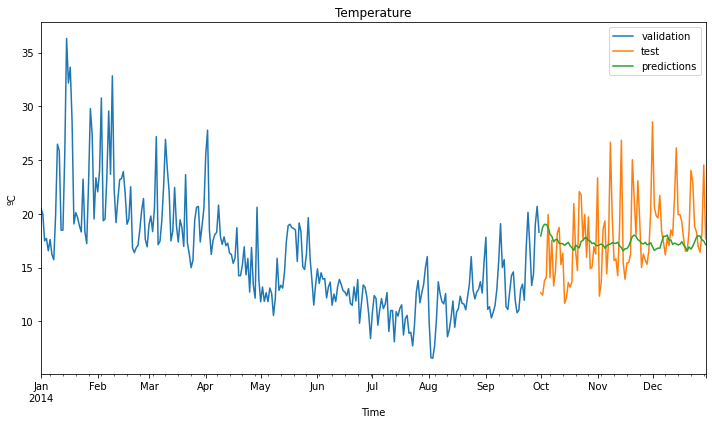

In [52]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 7,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data_val['Temperature'])

# Predict
# ==============================================================================
steps = len(data_test)

# Predictions for Temperature
predictions_temp = forecaster.predict(steps=steps)
error_mse = mean_squared_error(
                y_true = data_test.Temperature,
                y_pred = predictions_temp
            )
print(f"Test error (mse): {error_mse}")
display(predictions_temp.head(3))

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# data_train['Temperature'].plot(label='train', ax=ax)
data_val['Temperature'].plot(label='validation', ax=ax)
data_test['Temperature'].plot(label='test', ax=ax)
predictions_temp.plot(ax=ax, label='predictions')
ax.set_ylabel('ºC')
ax.set_title('Temperature')
ax.legend()

fig.tight_layout()
plt.show();

2014-10-01    217492.867188
2014-10-02    218496.618849
2014-10-03    217025.144798
Freq: D, Name: pred, dtype: float64

2014-10-01    17.194066
2014-10-02    16.112023
2014-10-03    15.377742
Freq: D, Name: pred, dtype: float64

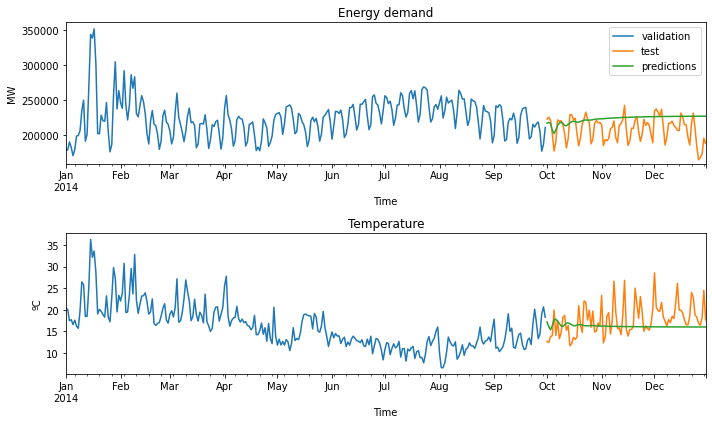

In [37]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = Ridge(random_state=123),
                 lags = 7,
                 transformer_series = StandardScaler()
             )

forecaster.fit(series=data_val[['Demand', 'Temperature']])

# Predict
# ==============================================================================
steps = len(data_test)

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps, level='Demand')
display(predictions_demand.head(3))

# Predictions for Temperature
predictions_temp = forecaster.predict(steps=steps, level='Temperature')
display(predictions_temp.head(3))

# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# data_train['Demand'].plot(label='train', ax=axes[0])
data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(ax=axes[0], label='predictions')
axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

# data_train['Temperature'].plot(label='train', ax=axes[1])
data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(ax=axes[1], label='predictions')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

2014-10-01    218949.733658
2014-10-02    221524.894047
2014-10-03    222455.623888
Freq: D, Name: pred, dtype: float64

2014-10-01     83.398395
2014-10-02    146.987394
2014-10-03    172.538783
Freq: D, Name: pred, dtype: float64

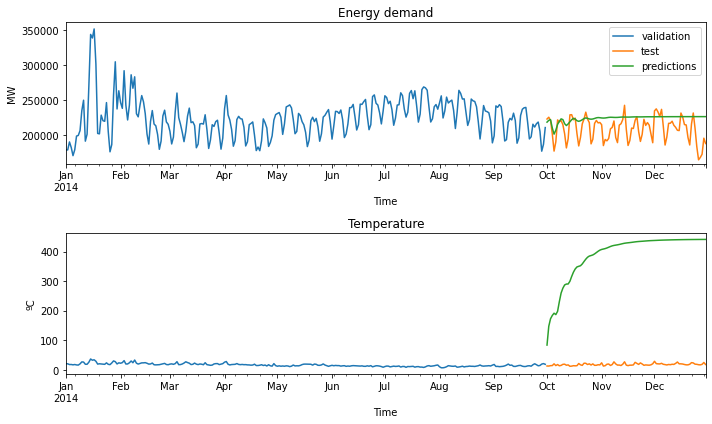

In [38]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = Ridge(random_state=123),
                 lags = 7,
                 transformer_series = None
             )

forecaster.fit(series=data_val[['Demand', 'Temperature']])

# Predict
# ==============================================================================
steps = len(data_test)

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps, level='Demand')
display(predictions_demand.head(3))

# Predictions for Temperature
predictions_temp = forecaster.predict(steps=steps, level='Temperature')
display(predictions_temp.head(3))

# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# data_train['Demand'].plot(label='train', ax=axes[0])
data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(ax=axes[0], label='predictions')
axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

# data_train['Temperature'].plot(label='train', ax=axes[1])
data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(ax=axes[1], label='predictions')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

## Backtesting LinearRegression

In [104]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})

data.head()

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,8646.190700,21.225,True
2011-12-31 15:00:00,7926.529376,20.625,True
2011-12-31 16:00:00,7901.826990,20.325,True
2011-12-31 17:00:00,7255.721350,19.850,True
2011-12-31 18:00:00,6792.503352,19.025,True


In [110]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates       : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


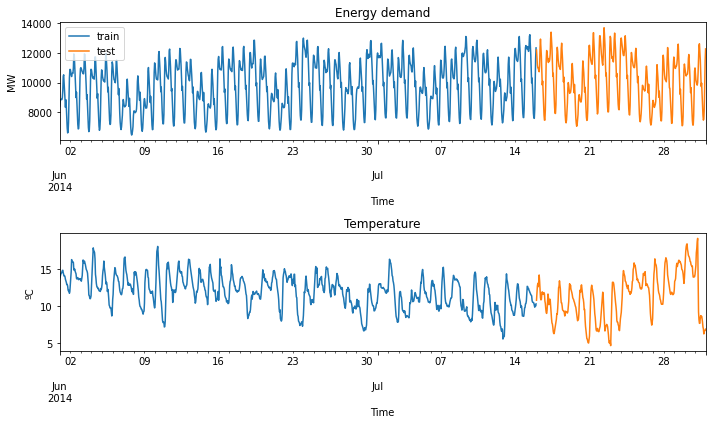

In [111]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_train['Demand'].plot(label='train', ax=axes[0])
# data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
# data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

Backtest error Demand: 571.2243117377348


,pred
2014-07-16 00:00:00,12650.090315
2014-07-16 01:00:00,12481.753017
2014-07-16 02:00:00,12106.341026
2014-07-16 03:00:00,12022.826511


Backtest error Temperature: 1.749642786356965


,pred
2014-07-16 00:00:00,10.731159
2014-07-16 01:00:00,11.267491
2014-07-16 02:00:00,12.057060
2014-07-16 03:00:00,12.721039


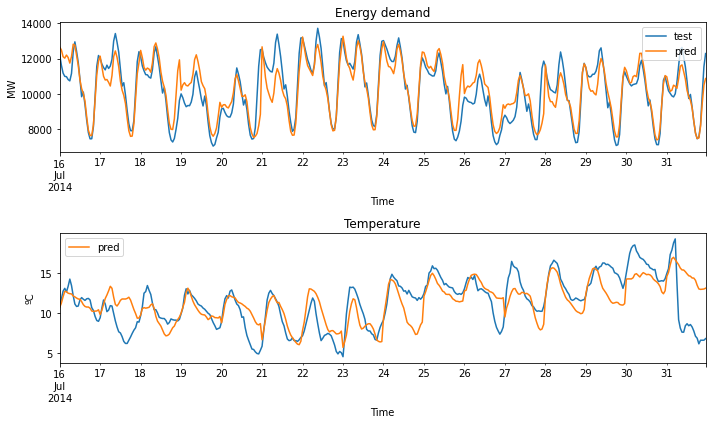

In [119]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 24
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

Backtest error Demand: 571.4134663574489


,pred
2014-07-16 00:00:00,12579.030740
2014-07-16 01:00:00,12531.893946
2014-07-16 02:00:00,12297.767311
2014-07-16 03:00:00,12153.645092


Backtest error Temperature: 1.7763198475970068


,pred
2014-07-16 00:00:00,10.699422
2014-07-16 01:00:00,11.235356
2014-07-16 02:00:00,11.950058
2014-07-16 03:00:00,12.452498


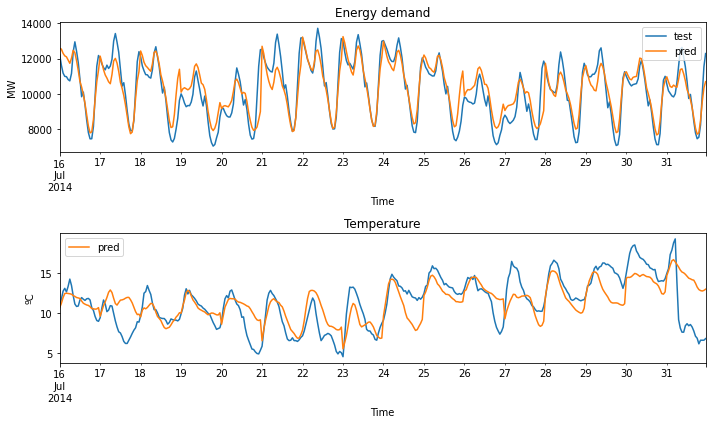

In [120]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 24,
                 transformer_series = StandardScaler()
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

Backtest error Demand: 571.2244590707918


,pred
2014-07-16 00:00:00,12650.091564
2014-07-16 01:00:00,12481.753636
2014-07-16 02:00:00,12106.340742
2014-07-16 03:00:00,12022.826673


Backtest error Temperature: 1.880719165192108


,pred
2014-07-16 00:00:00,10.707502
2014-07-16 01:00:00,11.171154
2014-07-16 02:00:00,11.643497
2014-07-16 03:00:00,11.964451


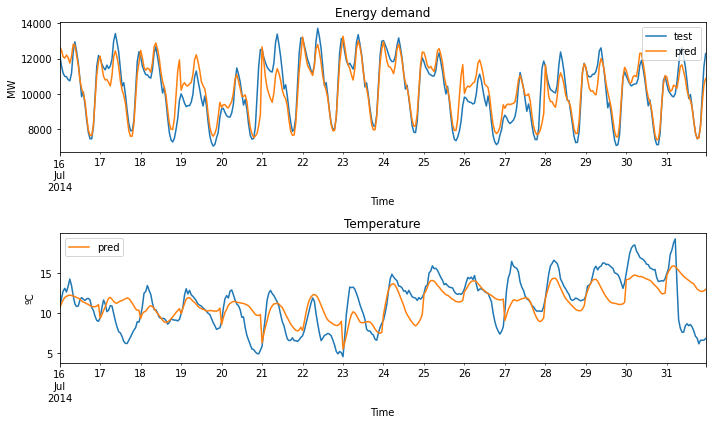

In [124]:
forecaster = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags = 24,
                 transformer_y = StandardScaler()
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = data['Demand'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = data['Temperature'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

In [127]:
data['Temperature'] = np.random.normal(size=len(data), loc=10, scale=1)

# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates       : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


Backtest error Demand: 803.8466409223665


,pred
2014-07-16 00:00:00,11760.351343
2014-07-16 01:00:00,11757.701195
2014-07-16 02:00:00,11730.191902
2014-07-16 03:00:00,11584.744763


Backtest error Temperature: 0.8127334396411389


,pred
2014-07-16 00:00:00,10.152297
2014-07-16 01:00:00,10.317405
2014-07-16 02:00:00,10.171000
2014-07-16 03:00:00,9.751314


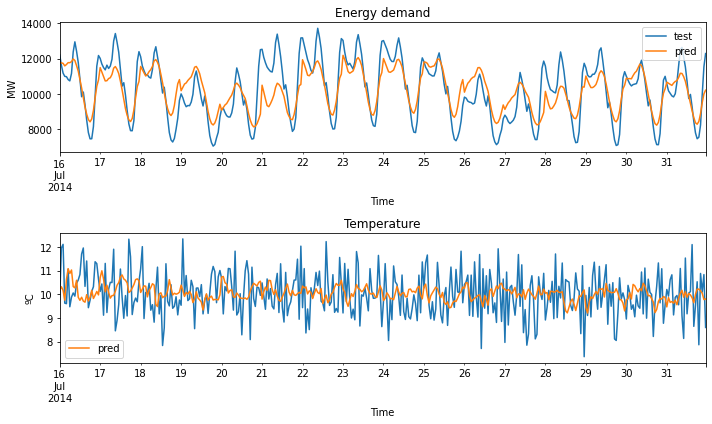

In [128]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 24,
                 transformer_series = StandardScaler()
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

## Backtesting RandomForest

Train dates      : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates       : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


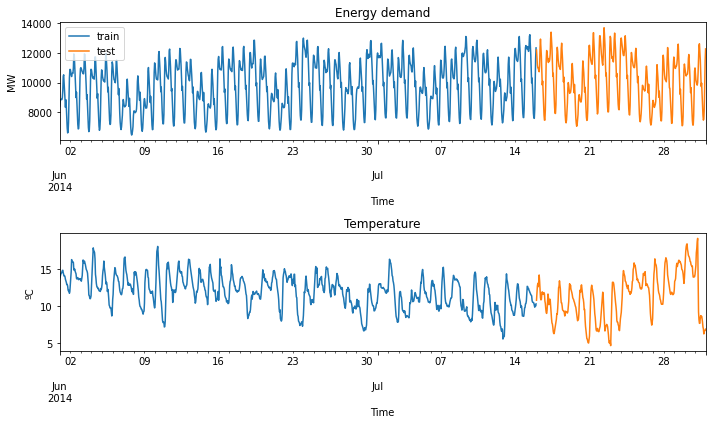

In [134]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})

# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_train['Demand'].plot(label='train', ax=axes[0])
# data_val['Demand'].plot(label='validation', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
# data_val['Temperature'].plot(label='validation', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

Backtest error Demand: 674.4880526625003


,pred
2014-07-16 00:00:00,12335.960094
2014-07-16 01:00:00,12180.476409
2014-07-16 02:00:00,11942.687506
2014-07-16 03:00:00,11789.402862


Backtest error Temperature: 1.9924921875000006


,pred
2014-07-16 00:00:00,10.7145
2014-07-16 01:00:00,10.9240
2014-07-16 02:00:00,10.7885
2014-07-16 03:00:00,10.6925


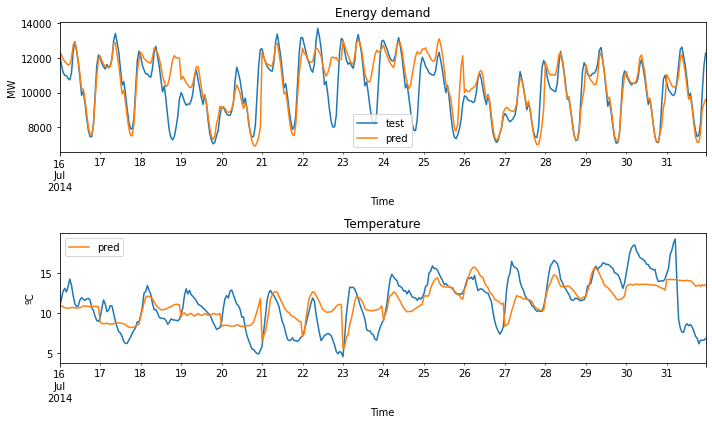

In [130]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 24
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

Backtest error Demand: 652.572748028207


,pred
2014-07-16 00:00:00,12665.133096
2014-07-16 01:00:00,12572.612902
2014-07-16 02:00:00,12385.549872
2014-07-16 03:00:00,12336.734757


Backtest error Temperature: 2.025227192031053


,pred
2014-07-16 00:00:00,10.669350
2014-07-16 01:00:00,11.108100
2014-07-16 02:00:00,11.391542
2014-07-16 03:00:00,11.651222


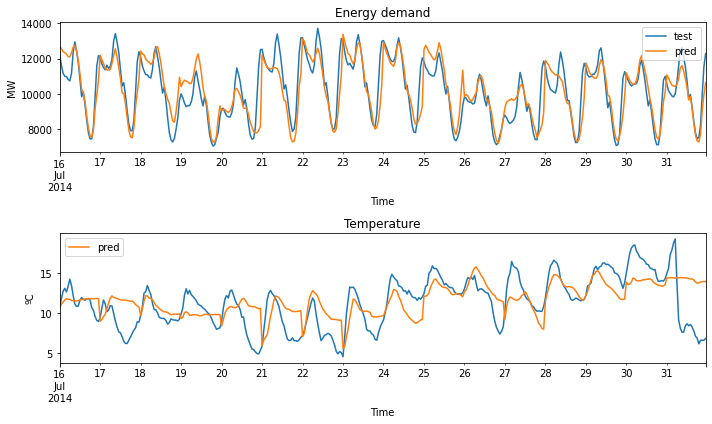

In [131]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 24,
                 transformer_series = StandardScaler()
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

Backtest error Demand: 632.2533796146874


,pred
2014-07-16 00:00:00,12410.304332
2014-07-16 01:00:00,12233.497860
2014-07-16 02:00:00,12056.796193
2014-07-16 03:00:00,11962.894859


Backtest error Temperature: 2.1814361979166663


,pred
2014-07-16 00:00:00,10.6795
2014-07-16 01:00:00,10.9325
2014-07-16 02:00:00,11.2840
2014-07-16 03:00:00,11.5740


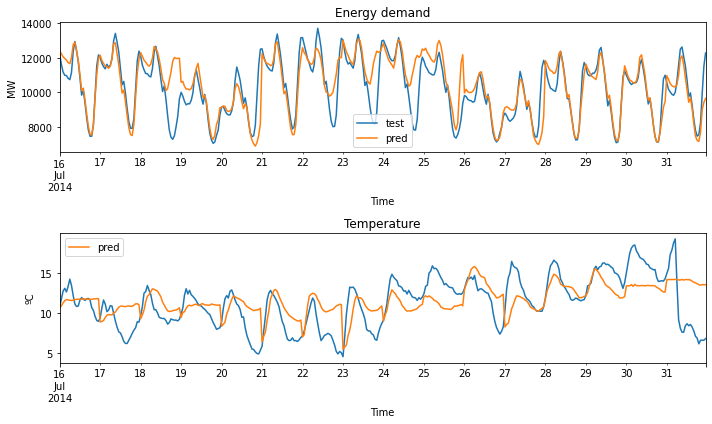

In [135]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 24,
                 transformer_y = StandardScaler()
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = data['Demand'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = data['Temperature'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

In [146]:
data['Temperature'] = np.random.normal(size=len(data), loc=10, scale=3)

# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates       : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


Backtest error Demand: 963.696155761184


,pred
2014-07-16 00:00:00,12110.329813
2014-07-16 01:00:00,12102.276824
2014-07-16 02:00:00,12102.276824
2014-07-16 03:00:00,12102.276824


Backtest error Temperature: 2.361572140313283


,pred
2014-07-16 00:00:00,9.962781
2014-07-16 01:00:00,9.995124
2014-07-16 02:00:00,9.668807
2014-07-16 03:00:00,9.857787


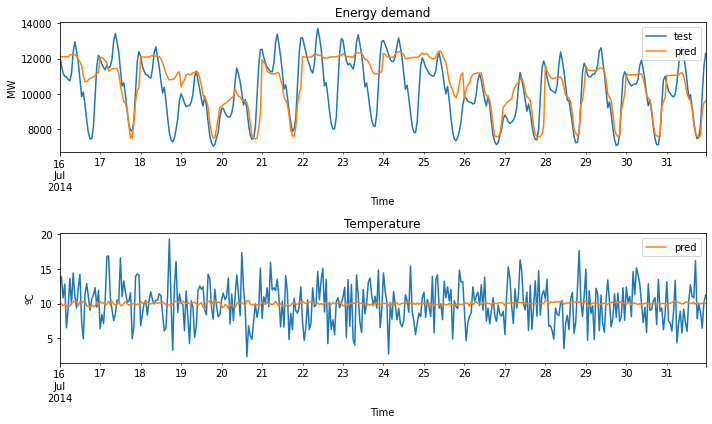

In [147]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123, max_depth=4),
                 lags = 24,
                 transformer_series = StandardScaler()
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
# axes[0].set_ylim(bottom=160_000)
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temp.plot(label='pred', ax=axes[1])
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

In [148]:
from sklearn import tree

forecaster.fit(series = data[['Demand', 'Temperature']])
text_representation = tree.export_text(forecaster.regressor.estimators_[58])
print(text_representation)

|--- feature_0 <= 0.30
|   |--- feature_23 <= -1.01
|   |   |--- feature_24 <= 0.50
|   |   |   |--- feature_15 <= 0.34
|   |   |   |   |--- value: [0.27]
|   |   |   |--- feature_15 >  0.34
|   |   |   |   |--- value: [-0.53]
|   |   |--- feature_24 >  0.50
|   |   |   |--- feature_4 <= -0.90
|   |   |   |   |--- value: [-0.40]
|   |   |   |--- feature_4 >  -0.90
|   |   |   |   |--- value: [-1.42]
|   |--- feature_23 >  -1.01
|   |   |--- feature_22 <= 0.80
|   |   |   |--- feature_22 <= -2.72
|   |   |   |   |--- value: [1.94]
|   |   |   |--- feature_22 >  -2.72
|   |   |   |   |--- value: [-0.27]
|   |   |--- feature_22 >  0.80
|   |   |   |--- feature_9 <= -1.87
|   |   |   |   |--- value: [2.60]
|   |   |   |--- feature_9 >  -1.87
|   |   |   |   |--- value: [0.14]
|--- feature_0 >  0.30
|   |--- feature_25 <= 0.50
|   |   |--- feature_0 <= 1.12
|   |   |   |--- feature_22 <= 0.66
|   |   |   |   |--- value: [0.49]
|   |   |   |--- feature_22 >  0.66
|   |   |   |   |--- value: 

## Feature importance

Since `ForecasterAutoregDirect` fits one model per step, it is necessary to specify from which model retrieves its feature importance.

In [40]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.977402
1,lag_2,-0.551707
2,lag_3,0.296737
3,lag_4,-0.130408
4,lag_5,-0.067784
5,lag_6,0.370986
6,lag_7,-0.051051
7,Demand,17636.775429
8,Temperature,-17636.775429


## Extract training matrix

Two steps are needed. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [16]:
X, y = forecaster.create_train_X_y(data_train)
# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
                step    = 1,
                X_train = X,
                y_train = y,
           )

X_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1995-09-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795
1995-10-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906
1995-11-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159
1995-12-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543


In [17]:
y_1.head(4)

datetime
1995-09-01    0.595223
1995-10-01    0.771258
1995-11-01    0.751503
1995-12-01    0.387554
Freq: MS, Name: y_step_1, dtype: float64

In [18]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>